## Introduction

This project explores the intricate relationships between Pokémon attributes and their primary and secondary typings by leveraging machine learning techniques. By analyzing a rich dataset containing features such as base stats, type defenses, and statuses, we sought to uncover patterns in type distributions and associations, highlighting the strategic design choices within the Pokémon universe.

To achieve this, we developed a predictive model capable of accurately identifying Pokémon typings based on their attributes. Using a random forest algorithm, the model achieved a remarkable accuracy of 93.78% for primary typings and 94.26% for secondary typings, demonstrating its effectiveness in capturing the complex interplay of features.

To make these insights accessible and actionable, we implemented the model into a web application built with React and Flask. The application provides an intuitive interface for users to input Pokémon and receive effective recommendations for battles, showcasing the practical potential of combining machine learning with interactive web technologies.

Link to Project: <https://github.com/vinukranaweera/pokemon-recommender>

Link to Demo: <https://pokemon-recommender.vercel.app/>

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set_theme()

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [2]:
pokemon_df = pd.read_csv('/kaggle/input/pokemon-data-gen-i-to-gen-viii/pokedex_data.csv')

In [3]:
pokemon_df.head()

,Unnamed: 0,pokedex_number,name,german_name,japanese_name,generation,status,species,type_number,type_1,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,0,1,Bulbasaur,Bisasam,フシギダネ (Fushigidane),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,1,2,Ivysaur,Bisaknosp,フシギソウ (Fushigisou),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,2,3,Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
3,3,3,Mega Venusaur,Bisaflor,フシギバナ (Fushigibana),1,Normal,Seed Pokémon,2,Grass,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
4,4,4,Charmander,Glumanda,ヒトカゲ (Hitokage),1,Normal,Lizard Pokémon,1,Fire,...,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5


In [4]:
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045 entries, 0 to 1044
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1045 non-null   int64  
 1   pokedex_number    1045 non-null   int64  
 2   name              1045 non-null   object 
 3   german_name       1045 non-null   object 
 4   japanese_name     1045 non-null   object 
 5   generation        1045 non-null   int64  
 6   status            1045 non-null   object 
 7   species           1045 non-null   object 
 8   type_number       1045 non-null   int64  
 9   type_1            1045 non-null   object 
 10  type_2            553 non-null    object 
 11  height_m          1045 non-null   float64
 12  weight_kg         1044 non-null   float64
 13  abilities_number  1045 non-null   int64  
 14  ability_1         1042 non-null   object 
 15  ability_2         516 non-null    object 
 16  ability_hidden    813 non-null    object 


**Observations**

* The dataset includes several fields that will be relevant towards training our predictive models: 
    - Name of the Pokemon
    - Status of the Pokemon: Normal, Mythical, Sub-legendary, Legendary
    - Secondary Typing (type_2)
    - Base/Total Stats (HP, Attack, Defense, etc.)
    - Type Defenses (against_normal, against_fighting)


In [5]:
pokemon_df.isnull().sum()

Unnamed: 0            0
pokedex_number        0
name                  0
german_name           0
japanese_name         0
generation            0
status                0
species               0
type_number           0
type_1                0
type_2              492
height_m              0
weight_kg             1
abilities_number      0
ability_1             3
ability_2           529
ability_hidden      232
total_points          0
hp                    0
attack                0
defense               0
sp_attack             0
sp_defense            0
speed                 0
catch_rate           18
base_friendship     115
base_experience     120
growth_rate           1
egg_type_number       0
egg_type_1            3
egg_type_2          760
percentage_male     173
egg_cycles            1
against_normal        0
against_fire          0
against_water         0
against_electric      0
against_grass         0
against_ice           0
against_fight         0
against_poison        0
against_ground  

**Observations**

* Most columns do not have null values such as the type defenses, stats, and generations.
* Some necessary columns like type_2, ability_2, and ability_hidden have null values, which is reasonable because there are Pokémon that do not have a second typing or second ability. However, the null values will need be filled in.
* Some unnecessary columns that may not be useful in predicting typing have null values such as egg_type, base_friendship, and base_experience. These columns will be removed.

In [6]:
pokemon_df.describe()

,Unnamed: 0,pokedex_number,generation,type_number,height_m,weight_kg,abilities_number,total_points,hp,attack,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
count,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1044.000000,1045.000000,1045.000000,1045.000000,1045.000000,...,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000,1045.000000
mean,522.000000,440.769378,4.098565,1.529187,1.374067,71.216571,2.268900,439.353110,70.067943,80.476555,...,1.082297,1.168900,0.977273,0.998086,1.238278,1.018660,0.977033,1.071053,0.981579,1.091148
std,301.809819,262.517231,2.272788,0.499386,3.353349,132.259911,0.803154,121.992897,26.671411,32.432728,...,0.782683,0.592145,0.501934,0.610411,0.696560,0.568056,0.375812,0.465178,0.501753,0.536285
min,0.000000,1.000000,1.000000,1.000000,0.100000,0.100000,0.000000,175.000000,1.000000,5.000000,...,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000
25%,261.000000,212.000000,2.000000,1.000000,0.600000,9.000000,2.000000,330.000000,50.000000,55.000000,...,0.500000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000
50%,522.000000,436.000000,4.000000,2.000000,1.000000,29.500000,2.000000,458.000000,68.000000,77.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,783.000000,670.000000,6.000000,2.000000,1.600000,70.500000,3.000000,515.000000,82.000000,100.000000,...,1.500000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1044.000000,898.000000,8.000000,2.000000,100.000000,999.900000,3.000000,1125.000000,255.000000,190.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000


## Analysis

### Distribution of Secondary Types Among Each Primary Type

In [7]:
pokemon_df['type_2'].fillna(value='None', inplace=True)
pokemon_df['ability_1'].fillna(value='None', inplace=True)
pokemon_df['ability_2'].fillna(value='None', inplace=True)
pokemon_df['ability_hidden'].fillna(value='None', inplace=True)

<Figure size 1200x600 with 0 Axes>

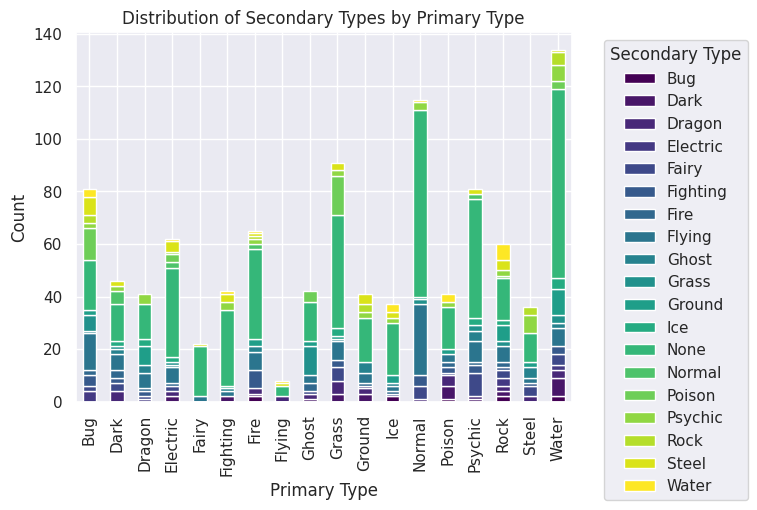

In [8]:
type_combinations = pd.crosstab(pokemon_df['type_1'], pokemon_df['type_2'])

# Create a stacked bar chart
plt.figure(figsize=(12, 6))
type_combinations.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Secondary Types by Primary Type')
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Secondary Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Observations**

* The Normal primary type has the highest total count, showing a wide variety of secondary types paired with it. This indicates Normal is a versatile primary type.

* Many primary types, including Normal, Bug, and Grass, frequently have Flying as their secondary type. This suggests a strong association between these two categories.

* Both Grass and Water primary types have significant counts and a wide variety of secondary types, highlighting their versatility.

* Certain secondary types like Steel and Ice are rare across all primary types, reflecting their niche role in this dataset.

### Distribution of Primary Types Among Each Secondary Type

<Figure size 1200x600 with 0 Axes>

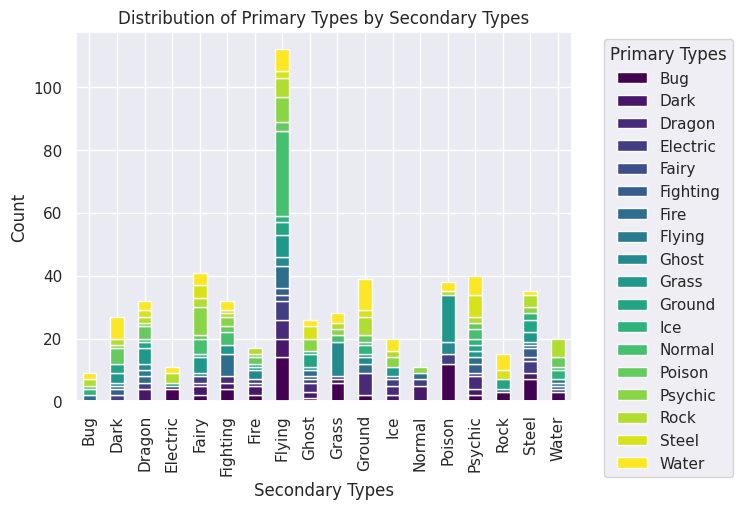

In [9]:
filtered_df = pokemon_df[(pokemon_df['type_1'] != "None") & (pokemon_df['type_2'] != "None")]

type_combinations2 = pd.crosstab(filtered_df['type_2'], filtered_df['type_1'])

plt.figure(figsize=(12, 6))
type_combinations2.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Primary Types by Secondary Types')
plt.xlabel('Secondary Types')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Primary Types', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Observations**

* Flying is the most common secondary type, appearing over 100 times across various primary types. This widespread distribution highlights its popularity as a complementary type.

* While Flying and Grass dominate secondary type pairings, other combinations such as Water, Ground, Poison, and Psychic also occur frequently. These combinations showcase the versatility of certain secondary types, though their distributions are more evenly spread across primary types.

* Some primary types exhibit diversity in their secondary type pairings, such as Bug and Dragon, which are paired with a wide variety of secondary types. Others, like Flying, Water, and Poison, are associated with a more specialized range of secondary types, reflecting niche combinations.

* Fairy and Psychic types are frequently paired with specific secondary types, as indicated by their distinct patterns and coloration. Conversely, secondary types like Dark and Ice tend to have fewer primary type pairings, suggesting they are blended with complementary abilities or traits less often.

* Some primary types, such as Ice and Steel, are underrepresented in type combinations. Fire, Electric, and Fairy also appear less frequently as secondary types, indicating a narrower application in type pairing strategies.

* Secondary types like Rock and Steel, while not dominant, show moderate representation. Their presence suggests a noticeable, albeit smaller, diversity of primary types compared to leading categories.

### Combinations not Present in Dataset

In [10]:
unique_type1 = pokemon_df['type_1'].unique()
unique_type2 = pokemon_df['type_2'].unique()

all_combinations = [(t1, t2) for t1 in unique_type1 for t2 in unique_type2]

combinations_in_dataset = set(zip(pokemon_df['type_1'], pokemon_df['type_2']))

combinations_not_in_dataset = [combo for combo in all_combinations if combo not in combinations_in_dataset]

print("\nType Combinations Not in the Dataset:")
for combo in combinations_not_in_dataset:
    print(combo)


Type Combinations Not in the Dataset:
('Grass', 'Normal')
('Grass', 'Grass')
('Grass', 'Electric')
('Grass', 'Rock')
('Grass', 'Water')
('Grass', 'Fire')
('Grass', 'Bug')
('Fire', 'Poison')
('Fire', 'Fairy')
('Fire', 'Grass')
('Fire', 'Electric')
('Fire', 'Ice')
('Fire', 'Fire')
('Water', 'Normal')
('Water', 'Water')
('Water', 'Fire')
('Bug', 'Dragon')
('Bug', 'Normal')
('Bug', 'Ice')
('Bug', 'Dark')
('Bug', 'Bug')
('Normal', 'Poison')
('Normal', 'Normal')
('Normal', 'Steel')
('Normal', 'Electric')
('Normal', 'Ice')
('Normal', 'Dark')
('Normal', 'Ghost')
('Normal', 'Rock')
('Normal', 'Fire')
('Normal', 'Bug')
('Dark', 'Poison')
('Dark', 'Ground')
('Dark', 'Electric')
('Dark', 'Dark')
('Dark', 'Rock')
('Dark', 'Water')
('Dark', 'Bug')
('Poison', 'Poison')
('Poison', 'Normal')
('Poison', 'Steel')
('Poison', 'Grass')
('Poison', 'Electric')
('Poison', 'Ice')
('Poison', 'Ghost')
('Poison', 'Rock')
('Electric', 'Ground')
('Electric', 'Fighting')
('Electric', 'Electric')
('Electric', 'Rock')

**Observations**

* Many potential type combinations, such as ('Grass', 'Normal'), ('Fire', 'Fairy'), and ('Bug', 'Dragon'), are not represented in the dataset. This indicates a lack of diversity in some type pairings and possibly the rarity or nonexistence of certain combinations in the Pokémon universe.

### Number of Each Combination in Dataset

In [11]:
all_combinations = [(t1, t2) for t1 in unique_type1 for t2 in unique_type2]

combination_counts = {}

for combo in all_combinations:
    count = len(pokemon_df[(pokemon_df['type_1'] == combo[0]) & (pokemon_df['type_2'] == combo[1])])
    if count > 0:
        combination_counts[combo] = count

print("Number of Each Combination in the Dataset:")
for combo, count in combination_counts.items():
    print(f"{combo}: {count} Pokémon")

Number of Each Combination in the Dataset:
('Grass', 'Poison'): 15 Pokémon
('Grass', 'None'): 43 Pokémon
('Grass', 'Flying'): 7 Pokémon
('Grass', 'Dragon'): 5 Pokémon
('Grass', 'Psychic'): 2 Pokémon
('Grass', 'Steel'): 3 Pokémon
('Grass', 'Ground'): 1 Pokémon
('Grass', 'Fairy'): 5 Pokémon
('Grass', 'Fighting'): 3 Pokémon
('Grass', 'Ice'): 3 Pokémon
('Grass', 'Dark'): 3 Pokémon
('Grass', 'Ghost'): 1 Pokémon
('Fire', 'None'): 34 Pokémon
('Fire', 'Flying'): 7 Pokémon
('Fire', 'Dragon'): 2 Pokémon
('Fire', 'Normal'): 2 Pokémon
('Fire', 'Psychic'): 2 Pokémon
('Fire', 'Steel'): 1 Pokémon
('Fire', 'Ground'): 3 Pokémon
('Fire', 'Fighting'): 7 Pokémon
('Fire', 'Dark'): 1 Pokémon
('Fire', 'Ghost'): 2 Pokémon
('Fire', 'Rock'): 1 Pokémon
('Fire', 'Water'): 1 Pokémon
('Fire', 'Bug'): 2 Pokémon
('Water', 'Poison'): 3 Pokémon
('Water', 'None'): 72 Pokémon
('Water', 'Flying'): 7 Pokémon
('Water', 'Dragon'): 3 Pokémon
('Water', 'Psychic'): 6 Pokémon
('Water', 'Steel'): 1 Pokémon
('Water', 'Ground'): 10

**Observations**

* Primary types like Water (72 Pokémon), Normal (71 Pokémon), and Psychic (45 Pokémon) often appear without a secondary type. This suggests these types are commonly used in their standalone form.

* Some primary-secondary combinations, such as ('Bug', 'Flying') with 14 Pokémon and ('Normal', 'Flying') with 27 Pokémon, are highly prevalent, showing a preference for these combinations in the dataset.

* Types like Ice and Steel are underrepresented as secondary types, with limited diversity in pairings. For instance, ('Ice', 'Bug') and ('Ice', 'Dark') each appear only twice, indicating fewer applications for these combinations.

* Some secondary types, such as Flying and Psychic, are paired with a wide range of primary types. For example, Flying appears as a secondary type in combinations like ('Grass', 'Flying'), ('Fire', 'Flying'), and ('Dark', 'Flying').

* Grass and Fire types show limited versatility in secondary type pairings, often being paired with fewer unique secondary types compared to Water or Bug.

### Percentage of Mono-Type and Dual-Type Pokemon

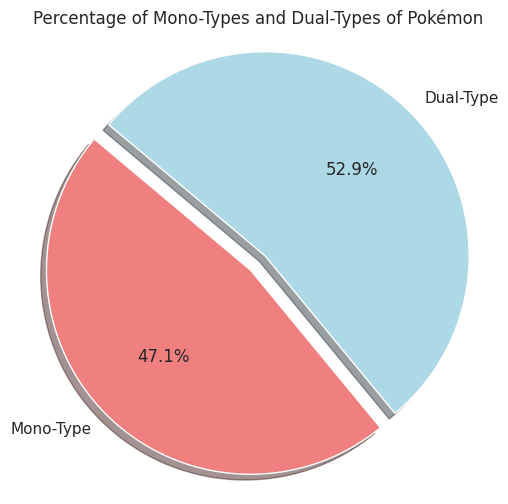

In [12]:
# Replace 'null' values with 'None' in the Type 2 column
# pokemon_df['Secondary Type'] = pokemon_df['Secondary Type'].fillna('None')

mono_type_count = (pokemon_df['type_2'] == 'None').sum()
dual_type_count = (pokemon_df['type_2'] != 'None').sum()

labels = ['Mono-Type', 'Dual-Type']
sizes = [mono_type_count, dual_type_count]
colors = ['lightcoral', 'lightblue']
explode = (0.1, 0)  # Explode the 1st slice (Mono-Type)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of Mono-Types and Dual-Types of Pokémon')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

plt.show()

**Observations**

* Dual-type Pokémon make up 52.9% of the dataset, indicating that a majority of Pokémon benefit from the added versatility of a second type. Mono-type Pokémon account for a substantial 47.1%, showing that nearly half of Pokémon remain focused on a single type, which might favor simplicity or specialization.

* The near 50-50 split highlights a balanced design approach, allowing for both specialized (mono-type) and versatile (dual-type) Pokémon within the game mechanics.

### Distribution of Primary Types

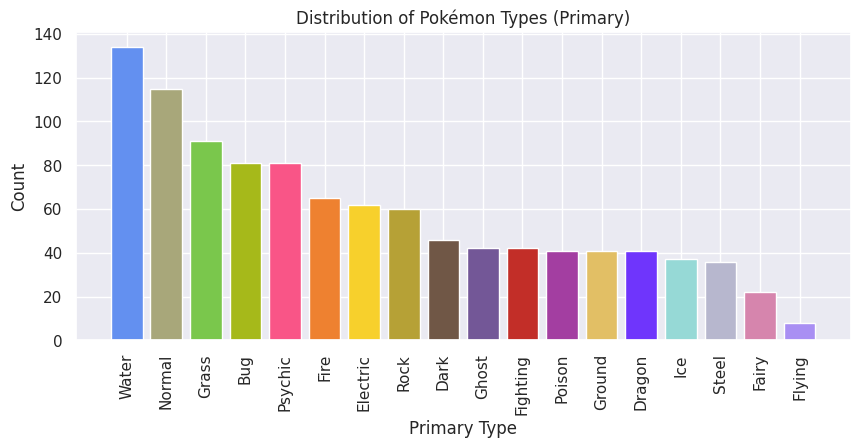

In [13]:
type_counts = pokemon_df['type_1'].value_counts()

types = type_counts.index
counts = type_counts.values

type_colors = {
    'Normal': '#A8A77A',
    'Fire': '#EE8130',
    'Water': '#6390F0',
    'Electric': '#F7D02C',
    'Grass': '#7AC74C',
    'Ice': '#96D9D6',
    'Fighting': '#C22E28',
    'Poison': '#A33EA1',
    'Ground': '#E2BF65',
    'Flying': '#A98FF3',
    'Psychic': '#F95587',
    'Bug': '#A6B91A',
    'Rock': '#B6A136',
    'Ghost': '#735797',
    'Dragon': '#6F35FC',
    'Dark': '#705746',
    'Steel': '#B7B7CE',
    'Fairy': '#D685AD'
};

colors = [type_colors.get(typ, 'gray') for typ in types]

plt.figure(figsize=(10, 4))
plt.bar(types, counts, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Primary Type')
plt.ylabel('Count')
plt.title('Distribution of Pokémon Types (Primary)')

plt.show()

**Observations**

* Water is the most common primary type, with the highest count among all types, showing its prevalence in the Pokémon dataset.
* These two types also have high frequencies, making them common choices for primary types.
* Types like Bug, Psychic, Fire, and Electric fall into a mid-range count, indicating they are fairly well-represented but not as dominant as Water or Normal.
* Primary types such as Dragon, Ice, Steel, and Fairy are among the least common, highlighting their rarity in comparison to others.
* Flying is significantly less frequent as a primary type, contrasting its prominence as a secondary type in the previous graph.

### Distribution of Secondary Types

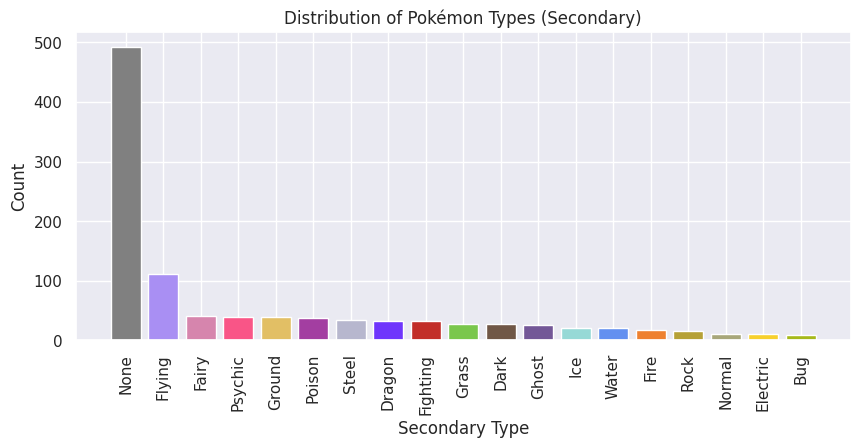

In [14]:
type_counts = pokemon_df['type_2'].value_counts()

types = type_counts.index
counts = type_counts.values

type_colors = {
    'Normal': '#A8A77A',
    'Fire': '#EE8130',
    'Water': '#6390F0',
    'Electric': '#F7D02C',
    'Grass': '#7AC74C',
    'Ice': '#96D9D6',
    'Fighting': '#C22E28',
    'Poison': '#A33EA1',
    'Ground': '#E2BF65',
    'Flying': '#A98FF3',
    'Psychic': '#F95587',
    'Bug': '#A6B91A',
    'Rock': '#B6A136',
    'Ghost': '#735797',
    'Dragon': '#6F35FC',
    'Dark': '#705746',
    'Steel': '#B7B7CE',
    'Fairy': '#D685AD'
};

colors = [type_colors.get(typ, 'gray') for typ in types]

plt.figure(figsize=(10, 4))
plt.bar(types, counts, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Secondary Type')
plt.ylabel('Count')
plt.title('Distribution of Pokémon Types (Secondary)')

plt.show()

**Observations**

* The majority of Pokémon do not have a secondary type, as represented by the None category, which has by far the highest count.
* Flying is the most frequent secondary type after "None," suggesting that many Pokémon that do have a secondary type pair it with Flying.
* Types like Fairy, Psychic, and Ground have notable frequencies, but still much lower than None or Flying.
* Categories such as Bug, Electric, Fire, and Rock appear much less often as secondary types, indicating they are less commonly paired with other types.
* Secondary types such as Dragon, Steel, and Ghost are present in a similar range, showing relatively rare but consistent pairings in the dataset.

### Average Base Stats According to Primary Type

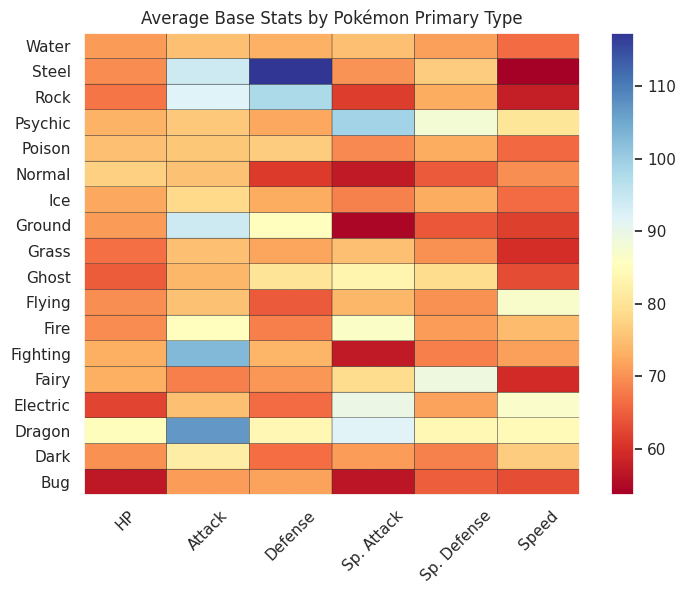

In [15]:
pokemon_df.rename(columns={'name':'Name', 'status':'Status', 'hp':'HP', 'attack':'Attack', 'defense':'Defense', 
                           'sp_attack':'Sp. Attack', 'sp_defense':'Sp. Defense', 'speed':'Speed'}, inplace=True)

numeric_attributes = ['HP', 'Attack', 'Defense', 'Sp. Attack', 'Sp. Defense', 'Speed']

type_mean_stats = pokemon_df.groupby('type_1')[numeric_attributes].mean()

plt.figure(figsize=(8, 6))
heatmap = plt.pcolor(type_mean_stats, cmap='RdYlBu', edgecolor='k')
plt.colorbar(heatmap)
plt.xticks(np.arange(len(numeric_attributes)) + 0.5, numeric_attributes, rotation=45)
plt.yticks(np.arange(len(type_mean_stats)) + 0.5, type_mean_stats.index)
plt.title('Average Base Stats by Pokémon Primary Type')
plt.show()

**Observations**

* Steel Pokémon stand out with the highest average Defense stats, making them the most defensively oriented primary type.

* Dragon Pokémon have strong averages in multiple categories, particularly Special Attack and HP, showing their role as powerful, well-rounded Pokémon.

* Bug Pokémon consistently rank among the lowest in almost all base stats, reflecting their tendency to be early-game or niche choices.

* Electric and Flying types excel in Speed, while Rock and Steel types are slower, highlighting a clear division between offensive/agile and defensive/slow archetypes.

* Both Rock and Ground types show above-average Defense and Special Defense, emphasizing their durability despite generally lower Speed.

* Types like Fire (Special Attack), Fighting (Attack), and Electric (Speed and Special Attack) lean heavily toward offensive capabilities.

### Distribution of Total Stats According to Primary Type

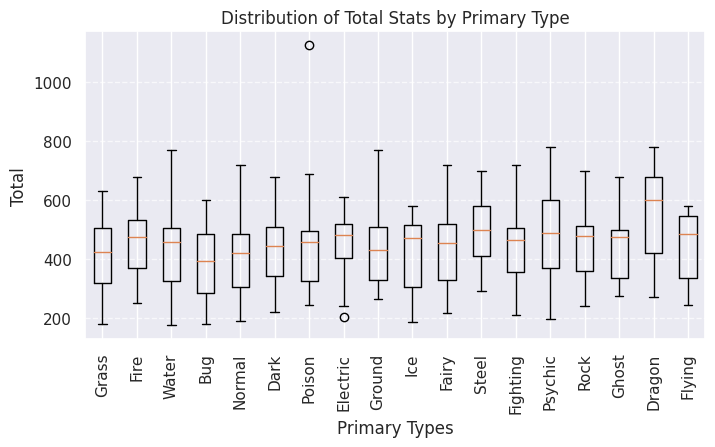

In [16]:
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)
plt.title('Distribution of Total Stats by Primary Type')
plt.xlabel('Primary Types')
plt.ylabel('Total')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.boxplot(
    [pokemon_df['total_points'][pokemon_df['type_1'] == t] for t in pokemon_df['type_1'].unique()],
    labels=pokemon_df['type_1'].unique()
)

plt.show()

**Observations**

* The Dragon type has the highest median and overall range of total stats, underscoring their role as powerful and often legendary Pokémon.

* Bug Pokémon have the lowest median and range of total stats, emphasizing their position as generally weaker or early-game options.

* Both Electric and Poison types show a wide spread in total stats, with some high-performing outliers, suggesting a mix of both weaker and stronger Pokémon in these categories.

* Types like Grass, Fire, Water, and Normal exhibit tight interquartile ranges, meaning the majority of Pokémon within these types have similar total stats.

* Some outliers are visible (e.g., high-performing Electric or Dragon types), indicating rare but exceptionally strong Pokémon within certain types.

* Types like Rock and Steel lean toward higher total stats, likely driven by their defensive capabilities.

### Distribution of Status According to Primary Type

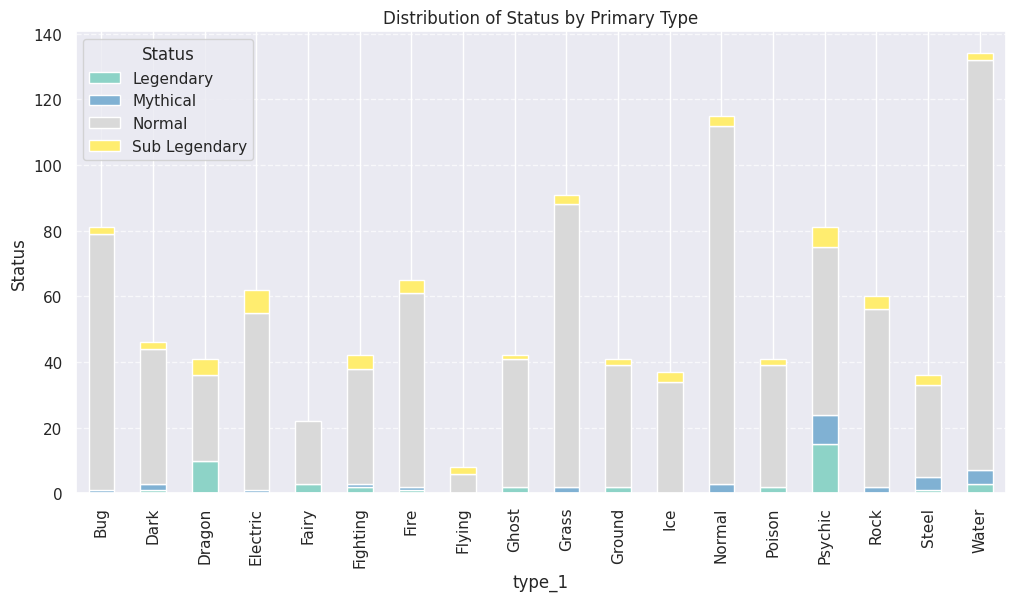

In [17]:
plt.figure(figsize=(12, 6))
plt.xticks(rotation=90)
plt.title('Distribution of Status by Primary Type')
plt.xlabel('Primary Type')
plt.ylabel('Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

status_count = pokemon_df.groupby(['type_1', 'Status']).size().unstack()

status_count.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3')

plt.show()

**Observations**

* The Normal type has the highest count of Pokémon, almost exclusively composed of Normal status (non-legendary, non-mythical, non-sub-legendary).

* The Water type not only has the highest count of Pokémon overall but also features a notable number of Sub-Legendaries, reflecting its diversity.

* These types have a relatively large proportion of Legendary and Mythical Pokémon, indicating their association with powerful or rare Pokémon.

* Both Bug and Poison types are overwhelmingly composed of Normal status Pokémon, highlighting their lower representation in rare or powerful categories.

* Types like Ice, Ground, and Fire have a significant number of Sub-Legendary Pokémon, suggesting their role in balancing power levels across various primary types.

* Despite its strategic importance, Fairy has relatively few Legendary or Sub-Legendary Pokémon, making it unique in this distribution.

## Cleaning the Dataset

#### Remove Unnecessary Columns

In [18]:
pokemon_df = pokemon_df.drop(['german_name', 'species', 'japanese_name', 'base_friendship', 'base_experience', 'egg_type_number',
                              'abilities_number', 'percentage_male', 'height_m', 'weight_kg', 'growth_rate',
                               'egg_type_1', 'egg_type_2', 'egg_cycles', 'pokedex_number'], axis=1)

#### Rename Columns and Fill Remaining Null Values

In [19]:
pokemon_df.rename(columns={'Unnamed: 0':'pokedex_number', 'Name':'name', 'Status':'status',
                           'type_1':'primary_type', 'type_2':'secondary_type', 'against_fight':'against_fighting'}, inplace=True)
pokemon_df['catch_rate'].fillna(value='None', inplace=True)

In [20]:
pokemon_df.isnull().sum()

pokedex_number      0
name                0
generation          0
status              0
type_number         0
primary_type        0
secondary_type      0
ability_1           0
ability_2           0
ability_hidden      0
total_points        0
HP                  0
Attack              0
Defense             0
Sp. Attack          0
Sp. Defense         0
Speed               0
catch_rate          0
against_normal      0
against_fire        0
against_water       0
against_electric    0
against_grass       0
against_ice         0
against_fighting    0
against_poison      0
against_ground      0
against_flying      0
against_psychic     0
against_bug         0
against_rock        0
against_ghost       0
against_dragon      0
against_dark        0
against_steel       0
against_fairy       0
dtype: int64

In [21]:
pokemon_df.head()

,pokedex_number,name,generation,status,type_number,primary_type,secondary_type,ability_1,ability_2,ability_hidden,...,against_ground,against_flying,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy
0,0,Bulbasaur,1,Normal,2,Grass,Poison,Overgrow,None,Chlorophyll,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
1,1,Ivysaur,1,Normal,2,Grass,Poison,Overgrow,None,Chlorophyll,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
2,2,Venusaur,1,Normal,2,Grass,Poison,Overgrow,None,Chlorophyll,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
3,3,Mega Venusaur,1,Normal,2,Grass,Poison,Thick Fat,None,None,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5
4,4,Charmander,1,Normal,1,Fire,None,Blaze,None,Solar Power,...,2.0,1.0,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5


#### Save Cleaned Dataset to CSV File

In [22]:
# Save the updated dataset
#pokemon_df.to_csv('updated_cleaned_pokemon_data.csv', index=False)
#pokemon_df.to_csv('cleaned_pokemon_data.csv', index=False)

## Modeling (Random Forest)

#### Preparing Data

Now that the data has been cleaned, it is time to choose features for our model. Since the dataset is large with many features, a random forest will perform better in terms of reducing overfitting and improving accuracy. To accurately identify the primary and secondary typing of Pokemon, we will use the 18 effectiveness multipliers (against_normal, against_fire, etc.) as well as generation and status. By utilizing the multipliers alone, we can achieve high accuracy because there is a direct correlation between typing and effectiveness against other types. Status and generation are also be two features that will prove effective in accurate predictions.  

In [23]:
# Map 'Status' to the corresponding index
status_mapping = {
    'Normal': 0,
    'Sub Legendary': 1,
    'Mythical': 2,
    'Legendary': 3
}

pokemon_df['status'] = pokemon_df['status'].map(status_mapping)

# Relevant features and target variables for primary and secondary types
X = pokemon_df[['generation', 'status', 'against_normal', 'against_fire', 'against_water', 'against_electric', 
                  'against_grass', 'against_ice', 'against_fighting', 'against_poison', 'against_ground', 'against_flying',
                  'against_psychic', 'against_bug', 'against_rock', 'against_ghost', 'against_dragon',
                  'against_dark', 'against_steel', 'against_fairy']]
y_primary = pokemon_df['primary_type']
y_secondary = pokemon_df['secondary_type']

#### Random Forest Model

In [24]:
# Split into training and testing sets
X_train, X_test, y_primary_train, y_primary_test, y_secondary_train, y_secondary_test = train_test_split(
    X, y_primary, y_secondary, test_size=0.2, random_state=42
)

In [25]:
# Train the classifier for primary typing
rf_classifier_primary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_primary.fit(X_train, y_primary_train)

RandomForestClassifier(random_state=42)

In [26]:
# Train the classifier for secondary typing
rf_classifier_secondary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_secondary.fit(X_train, y_secondary_train)

RandomForestClassifier(random_state=42)

In [27]:
# Test set to predict the primary and secondary typing of Pokemon
y_primary_pred = rf_classifier_primary.predict(X_test)
y_secondary_pred = rf_classifier_secondary.predict(X_test)

## Results

In [28]:
# Calculate accuracy and other evaluation metrics for primary typing
accuracy_primary = accuracy_score(y_primary_test, y_primary_pred)
classification_rep_primary = classification_report(y_primary_test, y_primary_pred)

print("Primary Typing Accuracy:", accuracy_primary)
print("Primary Typing Classification Report:\n", classification_rep_primary)

Primary Typing Accuracy: 0.937799043062201
Primary Typing Classification Report:
               precision    recall  f1-score   support

         Bug       1.00      0.87      0.93        15
        Dark       1.00      1.00      1.00        12
      Dragon       0.67      1.00      0.80         6
    Electric       1.00      1.00      1.00         6
       Fairy       1.00      0.75      0.86         4
    Fighting       1.00      1.00      1.00         5
        Fire       0.81      1.00      0.90        13
      Flying       1.00      1.00      1.00         2
       Ghost       0.89      0.80      0.84        10
       Grass       1.00      1.00      1.00        28
      Ground       1.00      0.89      0.94         9
         Ice       1.00      0.80      0.89        10
      Normal       0.94      1.00      0.97        29
      Poison       1.00      1.00      1.00         8
     Psychic       0.75      0.55      0.63        11
        Rock       1.00      1.00      1.00         9

**Observations**

* The model achieved a high accuracy of 93.78%, indicating strong performance across all typing classifications.

* Types like Dark, Electric, Fighting, Flying, Grass, Rock, Poison, and Water have perfect precision, recall, and F1-scores, showing excellent classification capability.

* Dragon has a lower precision (0.67) despite perfect recall (1.00), indicating some false positives for this type.

* Fairy and Psychic exhibit relatively lower recall (0.75 and 0.55, respectively), which means some true cases for these types are not being detected.

* Fire, Ghost, and Ice have slight dips in either precision or recall, but their F1-scores remain strong (0.84-0.90 range).

* Steel has a moderate precision (0.80) but achieves perfect recall (1.00), indicating occasional over-predictions.

* Based on weighted average precision, recall, and f1-score, all are 0.94, confirming that the model’s performance is consistent when weighted by the support of each type.

In [29]:
# Calculate accuracy and other evaluation metrics for secondary typing
accuracy_secondary = accuracy_score(y_secondary_test, y_secondary_pred)
classification_rep_secondary = classification_report(y_secondary_test, y_secondary_pred)

print("Secondary Typing Accuracy:", accuracy_secondary)
print("Secondary Typing Classification Report:\n", classification_rep_secondary)

Secondary Typing Accuracy: 0.9425837320574163
Secondary Typing Classification Report:
               precision    recall  f1-score   support

        Dark       1.00      1.00      1.00         5
      Dragon       1.00      0.75      0.86        12
    Electric       1.00      1.00      1.00         1
       Fairy       0.75      1.00      0.86         6
    Fighting       1.00      1.00      1.00         8
        Fire       1.00      0.67      0.80         3
      Flying       1.00      1.00      1.00        28
       Ghost       0.67      0.80      0.73         5
       Grass       1.00      1.00      1.00         7
      Ground       0.50      0.50      0.50         2
         Ice       0.67      0.80      0.73         5
        None       0.98      1.00      0.99        90
      Normal       1.00      0.33      0.50         3
      Poison       1.00      1.00      1.00         6
     Psychic       0.79      0.85      0.81        13
        Rock       1.00      1.00      1.00     

**Observations**

* The model achieved an accuracy of 94.26%, reflecting strong classification capabilities for secondary typing.

* Types like Dark, Electric, Fighting, Flying, Grass, Poison, Rock, and Water achieved perfect scores in precision, recall, and F1, indicating flawless classification for these types.

* Dragon achieved perfect precision (1.00) but lower recall (0.75), leading to an F1-score of 0.86. Fairy had excellent recall (1.00) but lower precision (0.75), resulting in an F1-score of 0.86. Steel got very high scores with slight variability in recall (0.90), producing an F1-score of 0.95.

* Ghost and Ice achieved moderate precision and recall (both around 0.67-0.80), leading to F1-scores of 0.73 for both. Psychic had good precision (0.79) and recall (0.85), resulting in an F1-score of 0.81.

* The precision and recall for Ground are both 0.50, resulting in a low F1-score of 0.50. The precision for Normal is high (1.00), but recall drops to 0.33, yielding an F1-score of 0.50. This suggests a high rate of false negatives.

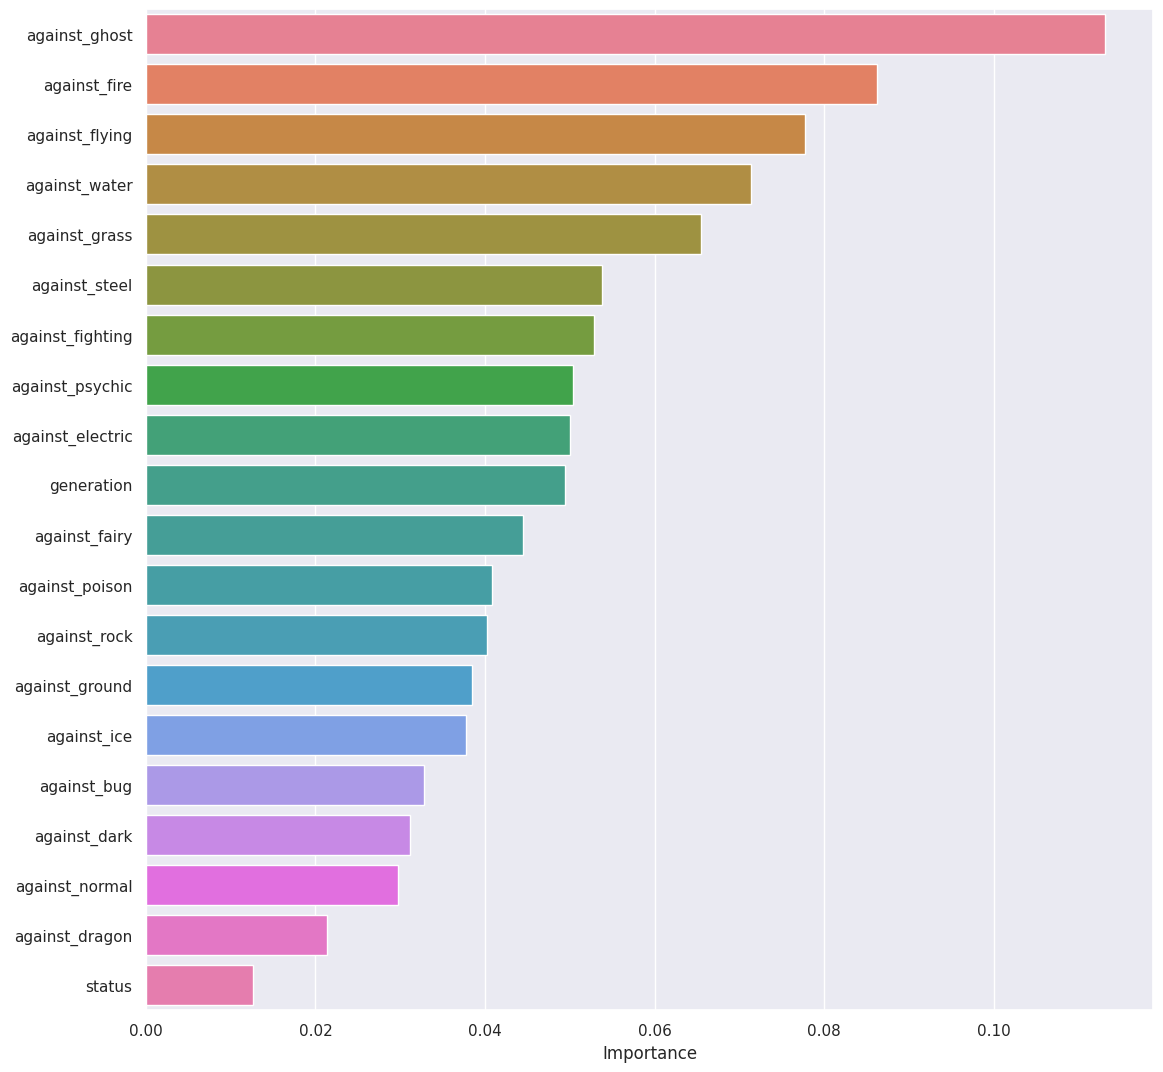

In [30]:
# Plot the feature importance for primary type

importances = rf_classifier_primary.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

palette = sns.color_palette("husl", len(importance_df))

sns.barplot(x=importance_df.Importance,y=importance_df.index, palette=palette);

**Observations**

* The top five most important features, based on their importance scores, are `against_ghost`, `against_fire`, `against_flying`, `against_water`, and `against_grass`. These features have the highest importance, suggesting they significantly influence the prediction or outcome in the model.

* Features like `against_steel`, `against_fighting`, `against_psychic`, and `against_electric` also have considerable importance, but they are less influential than the top five.

* Features such as `generation`, `against_fairy`, and `against_poison` contribute less to the model's decision-making, as they have lower importance scores.

* The least impactful features in the model are `status`, `against_dragon`, and `against_normal`, with very low importance scores. This suggests that these factors do not strongly affect the outcomes or predictions.

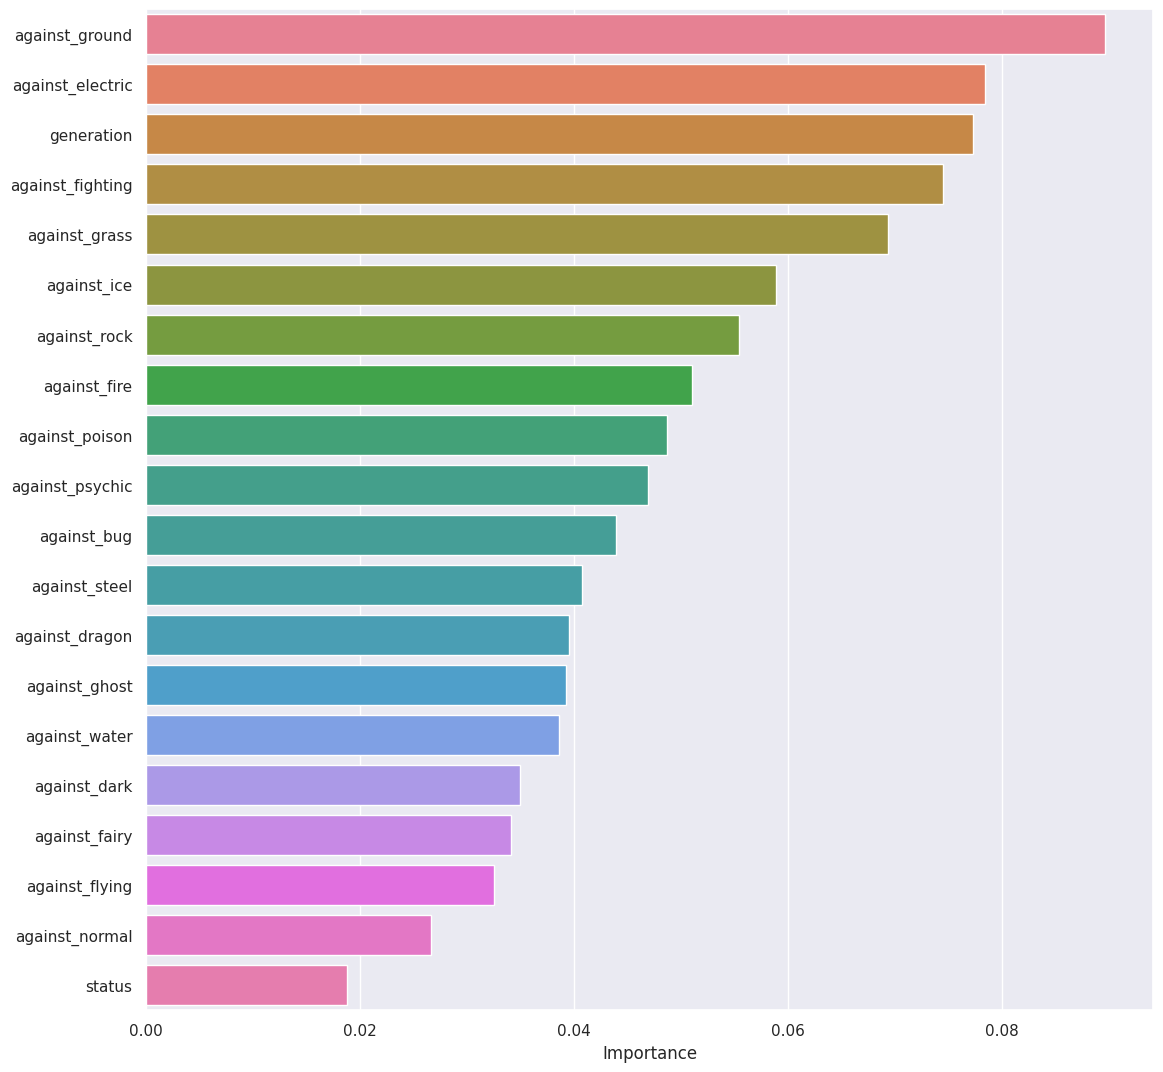

In [31]:
# Plot the feature importance for secondary type

importances = rf_classifier_secondary.feature_importances_

columns = X.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

palette = sns.color_palette("husl", len(importance_df))

sns.barplot(x=importance_df.Importance,y=importance_df.index, palette=palette);

**Observations**

* `against_ground` ranks as the most important feature, surpassing `against_ghost` from the previous chart. `against_electric`also appears higher in importance, moving up to a strong second place in this chart.

* Features like `against_ice`, `generation`, and `against_fighting` are more prominent in this chart than the previous one, showing they have a higher weight in this particular model.

* `against_water`, `against_flying`, `against_fire`, and `against_steel` drop significantly in importance in this chart, meaning these features play a lesser role than in the previous model.

* `status`, `against_dark`, `against_normal`, and `against_dragon` still have the least importance in both charts, consistently showing minimal influence on the model.

## Prediction of Pokemon Types

In [32]:
# Predicting types with the trained models
eval_data = X
predicted_primary_type = rf_classifier_primary.predict(eval_data)
predicted_secondary_type = rf_classifier_secondary.predict(eval_data)

# Create a DataFrame consisting of the original data along with predictions
result_df = eval_data.copy()
result_df['Predicted Primary Type'] = predicted_primary_type
result_df['Predicted Secondary Type'] = predicted_secondary_type

In [33]:
result_df.head()

,generation,status,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,...,against_psychic,against_bug,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy,Predicted Primary Type,Predicted Secondary Type
0,1,0,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,Grass,Poison
1,1,0,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,Grass,Poison
2,1,0,1.0,2.0,0.5,0.5,0.25,2.0,0.5,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,Grass,Poison
3,1,0,1.0,1.0,0.5,0.5,0.25,1.0,0.5,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,Grass,Poison
4,1,0,1.0,0.5,2.0,1.0,0.50,0.5,1.0,1.0,...,1.0,0.5,2.0,1.0,1.0,1.0,0.5,0.5,Fire,None


### Predicted Types vs. Original Types

In [34]:
# Combine original and predicted primary and secondary types into tuples for comparison
result_df['Original Combination'] = list(zip(pokemon_df['primary_type'], pokemon_df['secondary_type']))
result_df['Predicted Combination'] = list(zip(result_df['Predicted Primary Type'], result_df['Predicted Secondary Type']))

# Calculate accuracy
total_rows = len(result_df)
correct_matches = sum(result_df['Original Combination'] == result_df['Predicted Combination'])
combination_accuracy = correct_matches / total_rows

print(f"Combination Accuracy: {combination_accuracy:.2%}")

Combination Accuracy: 97.89%


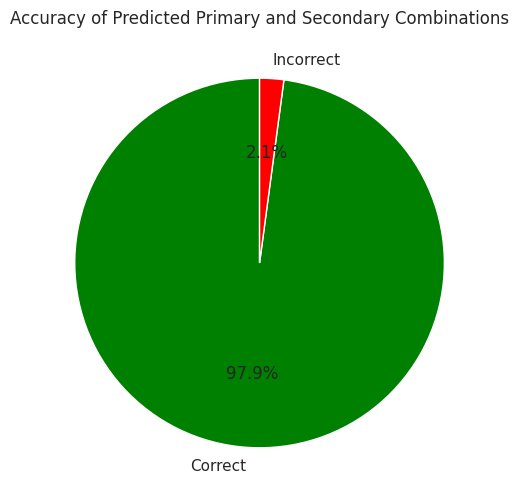

In [35]:
import matplotlib.pyplot as plt

correct_matches = sum(result_df['Original Combination'] == result_df['Predicted Combination'])
incorrect_matches = len(result_df) - correct_matches

accuracy_data = [correct_matches, incorrect_matches]
labels = ['Correct', 'Incorrect']
colors = ['green', 'red']

plt.figure(figsize=(8, 6))
plt.pie(accuracy_data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Accuracy of Predicted Primary and Secondary Combinations")
plt.show()

**Observations**

* The model predicts primary and secondary combinations with 97.9% accuracy, indicating that the predictions are mostly correct.

* Only 2.1% of the predictions are incorrect, suggesting a very low error rate in the chosen features and model’s predictions.

### Analysis of Incorrect Combinations

In [36]:
# Filter rows where the combinations do not match
mismatched_rows = result_df[result_df['Original Combination'] != result_df['Predicted Combination']]
mismatched_rows

,generation,status,against_normal,against_fire,against_water,against_electric,against_grass,against_ice,against_fighting,against_poison,...,against_rock,against_ghost,against_dragon,against_dark,against_steel,against_fairy,Predicted Primary Type,Predicted Secondary Type,Original Combination,Predicted Combination
35,1,0,1.0,1.0,1.0,0.0,1.0,1.0,1.00,1.00,...,1.0,1.0,1.0,1.0,0.5,1.0,Electric,None,"(Electric, Psychic)","(Electric, None)"
49,1,0,1.0,0.5,2.0,1.0,0.5,0.5,1.00,1.00,...,2.0,1.0,1.0,1.0,0.5,0.5,Fire,None,"(Ice, None)","(Fire, None)"
51,1,0,1.0,0.5,2.0,1.0,0.5,0.5,1.00,1.00,...,2.0,1.0,1.0,1.0,0.5,0.5,Fire,None,"(Ice, Fairy)","(Fire, None)"
100,1,0,1.0,0.0,2.0,1.0,0.5,0.5,1.00,1.00,...,2.0,1.0,1.0,1.0,0.5,0.5,Fire,None,"(Psychic, None)","(Fire, None)"
102,1,0,1.0,0.0,2.0,1.0,0.5,0.5,1.00,1.00,...,2.0,1.0,1.0,1.0,0.5,0.5,Fire,None,"(Psychic, Fairy)","(Fire, None)"
144,1,0,1.0,1.0,1.0,1.0,0.5,1.0,0.50,0.50,...,1.0,1.0,1.0,1.0,1.0,0.5,Poison,None,"(Poison, Fairy)","(Poison, None)"
145,1,0,0.5,0.5,4.0,0.0,4.0,2.0,2.00,0.25,...,0.5,1.0,1.0,1.0,2.0,1.0,Rock,Ground,"(Ground, Rock)","(Rock, Ground)"
146,1,0,0.5,0.5,4.0,0.0,4.0,2.0,2.00,0.25,...,0.5,1.0,1.0,1.0,2.0,1.0,Rock,Ground,"(Ground, Rock)","(Rock, Ground)"
158,1,0,1.0,1.0,1.0,1.0,1.0,1.0,0.25,1.50,...,1.0,1.5,0.0,1.0,1.5,1.0,Psychic,Fairy,"(Psychic, Ice)","(Psychic, Fairy)"
462,3,3,1.0,0.5,0.0,0.0,1.0,1.0,1.00,0.50,...,1.0,1.0,1.0,1.0,0.5,0.5,Fire,Ground,"(Ground, Fire)","(Fire, Ground)"


**Observations**

* In some instances, the predicted types match the original ones but are flagged as incorrect by the model due to their reversed order. While technically true, both type combinations are valid, as the order typically does not matter. This suggests that our model’s accuracy may be higher than initially perceived.

* In other instances, one or both predicted types differ from the original, highlighting opportunities for further refinement. Nonetheless, the majority of type combinations are accurately predicted, demonstrating the model’s ability to effectively identify the likely primary and secondary types for each Pokémon.

In [37]:
print(pokemon_df.iloc[[35, 49, 51, 100, 102, 144, 158, 568, 773, 934, 961, 962]])

     pokedex_number                name  generation  status  type_number  \
35               35       Alolan Raichu           1       0            2   
49               49       Alolan Vulpix           1       0            1   
51               51    Alolan Ninetales           1       0            2   
100             100     Galarian Ponyta           1       0            1   
102             102   Galarian Rapidash           1       0            2   
144             144    Galarian Weezing           1       0            2   
158             158   Galarian Mr. Mime           1       0            2   
568             568            Froslass           4       0            2   
773             773           Diggersby           6       0            2   
934             934  Dusk Mane Necrozma           7       3            2   
961             961             Dottler           8       0            2   
962             962            Orbeetle           8       0            2   

    primary

## Conclusion

This project successfully analyzed Pokémon attributes to develop a predictive model for determining primary and secondary type combinations. By leveraging a dataset enriched with features such as base stats, type defenses, and status, the analysis provided valuable insights into type distributions, associations, and strategic design patterns within the Pokémon universe. The following conclusions summarize the key achievements and findings:

1. **Insights on Pokémon Typing**
	* The dataset revealed critical patterns, such as the versatility of types like Normal, Grass, and Water, and the widespread pairing of Flying as a secondary type.
	* Underrepresented types such as Ice, Steel, and Dragon highlighted the rarity of certain combinations and the deliberate design choices in the Pokémon universe.
	* The diversity in type pairings, alongside the balanced distribution of mono-type and dual-type Pokémon, reflects a strategic approach to creating both specialized and versatile Pokémon.
    

2. **Data Preparation and Feature Engineering**
	* Null values in non-essential columns were effectively addressed, with irrelevant features removed to streamline model training.
	* Features like type effectiveness multipliers (e.g., against_fire), generation, and status proved pivotal for accurate predictions, while others, such as against_normal, had minimal impact.
    

3. **Model Performance**
	* A random forest model achieved high accuracy rates: 93.78% for primary typing and 94.26% for secondary typing, underscoring its robustness.
	* Perfect precision, recall, and F1-scores for types like Dark, Electric, and Water demonstrated flawless classification capabilities for these categories.
	* Challenges with types such as Dragon, Fairy, and Psychic, which exhibited lower precision or recall, highlighted areas for future refinement.
    

4. **Key Findings from Feature Importance Analysis**
    * Features like against_ghost, against_fire, and against_grass emerged as the most influential in the model’s decision-making process, aligning with the strong correlation between type effectiveness and type prediction.
	* Less impactful features like status and against_normal offered limited value in classification, confirming the importance of carefully selecting features for optimal performance.
    

5. **Model Strengths and Opportunities for Improvement**
    * The model’s ability to predict type combinations with 97.9% accuracy showcases its strength in deciphering complex relationships between attributes.
    * Occasional false positives and false negatives for specific types, such as Dragon and Psychic, indicate room for enhanced training with additional data or refined feature selection.
   

6. **Broader Implications** 
    * This analysis highlights how computational models can uncover patterns and relationships in complex datasets, offering potential applications in game design, balancing, and Pokémon strategy development.
    * The findings not only validate the effectiveness of the random forest approach but also emphasize the importance of feature engineering in predictive modeling tasks.

In conclusion, this project demonstrates the power of data-driven insights to decode the intricate relationships between Pokémon attributes and their typing. The high accuracy achieved by the model, coupled with the nuanced understanding of type distributions and associations, provides a solid foundation for future research and potential applications in machine learning and gaming analytics.